Background:

Our company develops innovative Artificial Intelligence and Computer Vision solutions that revolutionize industries. Machines that can see: We pack our solutions in small yet intelligent devices that can be easily integrated to your existing data flow. Computer vision for everyone: Our devices can recognize faces, estimate age and gender, classify clothing types and colors, identify everyday objects and detect motion. Technical consultancy: We help you identify use cases of artificial intelligence and computer vision in your industry. Artificial intelligence is the technology of today, not the future.

MonReader is a new mobile document digitization experience for the blind, for researchers and for everyone else in need for fully automatic, highly fast and high-quality document scanning in bulk. It is composed of a mobile app and all the user needs to do is flip pages and everything is handled by MonReader: it detects page flips from low-resolution camera preview and takes a high-resolution picture of the document, recognizing its corners and crops it accordingly, and it dewarps the cropped document to obtain a bird's eye view, sharpens the contrast between the text and the background and finally recognizes the text with formatting kept intact, being further corrected by MonReader's ML powered redactor.

Data Description:

We collected page flipping video from smart phones and labelled them as flipping and not flipping.

Goal(s):

Predict if the page is being flipped using a single image.

Success Metrics:

Evaluate model performance based on F1 score, the higher the better.

### Import Dependencies

In [1]:
!pip install keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras import models,layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Flatten, Dense, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications.vgg16 import VGG16
from keras import backend as K

import warnings
warnings.filterwarnings('ignore')

from src.visualization.visualize import visualize_data, model_performance

In [ ]:
#Check for GPU availability

print("GPU", "available (YES!!)" if tf.config.list_physical_devices("GPU") else "not available")

GPU available (YES!!)


### Load Dataset

In [3]:
train_set = tf.keras.utils.image_dataset_from_directory(
  '../data/raw/training',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(180, 180),
  batch_size=32
)

validation_set =  tf.keras.utils.image_dataset_from_directory(
  '../data/raw/training',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(180, 180),
  batch_size=32
)

test_set = tf.keras.utils.image_dataset_from_directory(
  '../data/raw/testing',
  batch_size=32,
  image_size=(180, 180),
  seed=123
)

Found 2392 files belonging to 2 classes.
Using 1914 files for training.
Found 2392 files belonging to 2 classes.
Using 478 files for validation.
Found 597 files belonging to 2 classes.


In [4]:
class_names = test_set.class_names
class_names

['flip', 'notflip']

In [ ]:
# shape of training data

for image_batch, labels_batch in train_set.take(1):
    print(image_batch.shape)
    print(labels_batch.shape)

(32, 180, 180, 3)
(32,)


In [ ]:
# shape of testing data

for image_batch, labels_batch in test_set.take(1):
    print(image_batch.shape)
    print(labels_batch.shape)

(32, 180, 180, 3)
(32,)


### Visualize Data

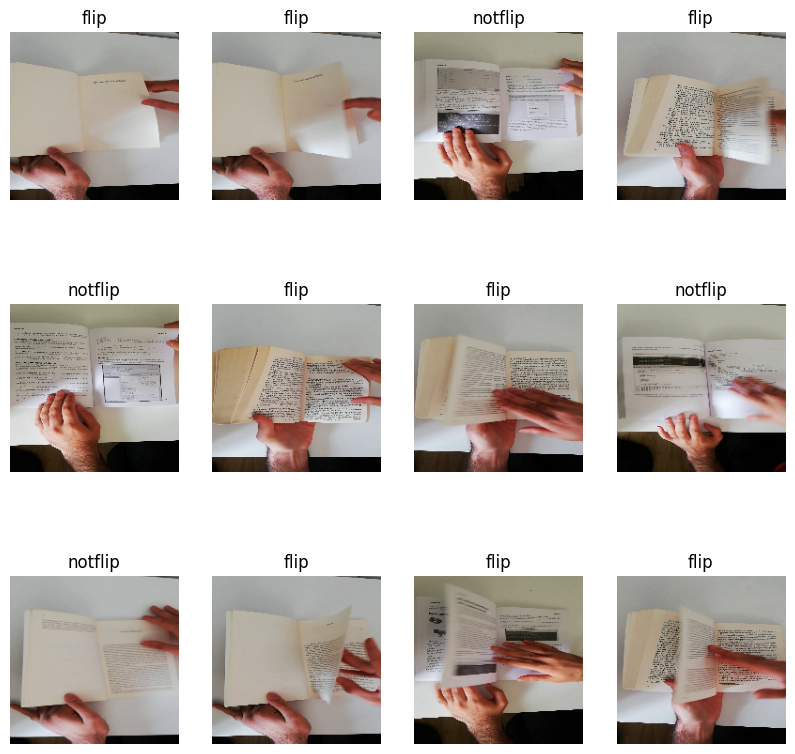

In [ ]:
# display few images in training set

visualize_data(train_set, class_names)

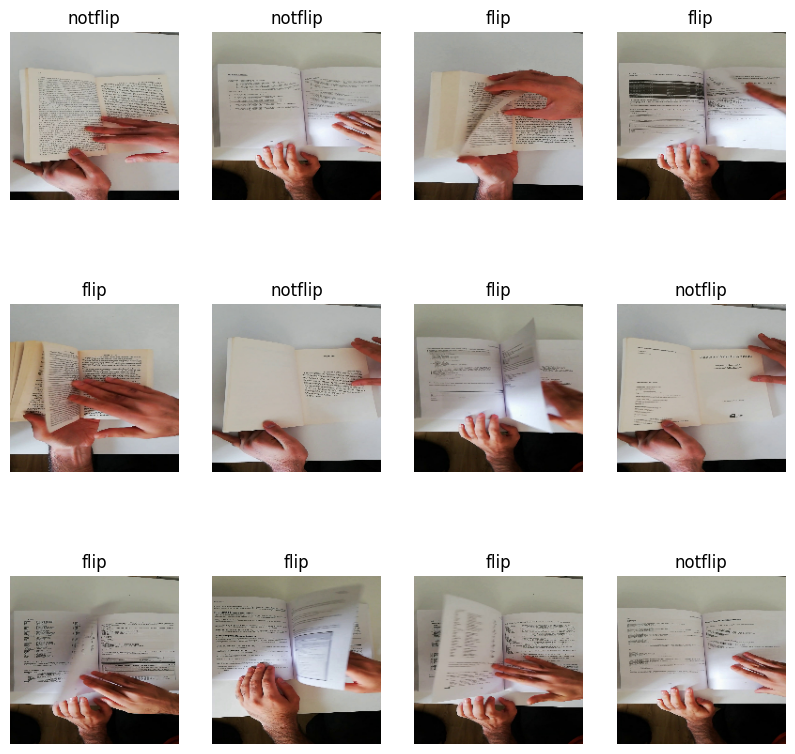

In [ ]:
# display few images in validation set

visualize_data(validation_set, class_names)

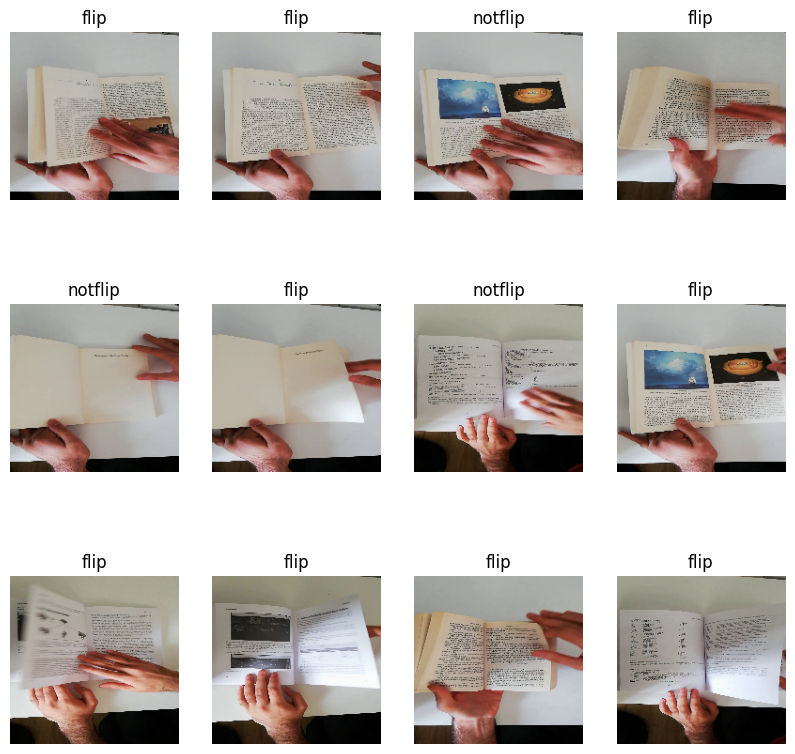

In [ ]:
# display few images in testing set

visualize_data(test_set, class_names)

### Configure Dataset

* The "cache()" method caches the elements of the dataset in memory or on disk, which can speed up the processing of the dataset, especially if the dataset is large and reading it from disk repeatedly would be slow.

* The "shuffle()" method shuffles the elements of the dataset. This helps ensure that the model does not learn the order of the examples in the dataset.

* The "prefetch()" method overlaps the preprocessing and model execution of a training step. This can provide a performance boost when reading from disk or when the model is being trained on a distributed system.

In [5]:
train_set = train_set.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_set = test_set.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_set = validation_set.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

### Normalize Dataset

Normalized data bu creating sequential layer that resizes the input image to 180x180 and then rescales the pixel values to be in the range [0,1]. This preprocessing step is commonly used to normalize the input data and improve the performance of the model. 

In [6]:
# resize and rescale

resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(180,180),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

### F1 - Score

In [7]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

### Model Comparison

Custom CNN along with 3 pre-trained model such as VGG16, ResNet50 and MobileNetV2 will be used to compare the models and select the model with best accuracy for the production.

### Custom CNN Model

Created a sequential model using the Sequential class from Keras. First layer of the model is to normalize the data. The model consists of three pairs of a convolutional layer and a max pooling layer, each with a ReLU activation function. The model is then flattened and passed through two dense layers with ReLU and sigmoid activation functions respectively.

In [8]:
model = Sequential()

model.add(resize_and_rescale)

model.add(Conv2D(60, (3,3), padding='same', activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(32, (3,3), padding='same', activation='relu'))  
model.add(MaxPooling2D(2,2))

model.add(Conv2D(32, (3,3), padding='same', activation='relu'))  
model.add(MaxPooling2D(2,2))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add( Dense(1, activation='sigmoid'))

model.build(input_shape=(32, 224, 224, 3))

In [9]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1_score])

# model summary
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 180, 180, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 180, 180, 60)        1680      
                                                                 
 max_pooling2d (MaxPooling2D  (32, 90, 90, 60)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 90, 90, 32)          17312     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 45, 45, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 45, 45, 32)         

In [10]:
history = model.fit(train_set, epochs=10, verbose=1, validation_data = validation_set)

Epoch 1/10
60/60 [==============================] - 210s 638ms/step - loss: 0.6263 - accuracy: 0.6285 - f1_score: 0.6377 - val_loss: 0.5312 - val_accuracy: 0.8013 - val_f1_score: 0.7995
Epoch 2/10
60/60 [==============================] - 2s 39ms/step - loss: 0.3178 - accuracy: 0.8804 - f1_score: 0.8795 - val_loss: 0.1757 - val_accuracy: 0.9519 - val_f1_score: 0.9526
Epoch 3/10
60/60 [==============================] - 2s 37ms/step - loss: 0.1163 - accuracy: 0.9592 - f1_score: 0.9587 - val_loss: 0.0665 - val_accuracy: 0.9833 - val_f1_score: 0.9821
Epoch 4/10
60/60 [==============================] - 2s 36ms/step - loss: 0.0671 - accuracy: 0.9770 - f1_score: 0.9772 - val_loss: 0.1320 - val_accuracy: 0.9477 - val_f1_score: 0.9508
Epoch 5/10
60/60 [==============================] - 2s 35ms/step - loss: 0.0573 - accuracy: 0.9796 - f1_score: 0.9794 - val_loss: 0.0435 - val_accuracy: 0.9812 - val_f1_score: 0.9807
Epoch 6/10
60/60 [==============================] - 2s 35ms/step - loss: 0.0328 - 

### Save Model

In [11]:
model.save('saved_model.h5')

In [12]:
import os

file_size = os.path.getsize('saved_model.h5') / (1024 * 1024)
print(f'Model size: {file_size:.2f} MB')

Model size: 23.06 MB


### Evaluate Model

In [13]:
scores_cutom_model = model.evaluate(test_set)

19/19 [==============================] - 69s 28ms/step - loss: 0.0754 - accuracy: 0.9765 - f1_score: 0.9746


In [14]:
print(f"The accuracy of the model on the training data: {np.max(history.history['accuracy']):.4f}")
print(f"The accuracy of the model on the testing data: {np.max(history.history['val_accuracy']):.4f}")
print(f"\nThe F1-Score of the model on the training data: {np.max(history.history['f1_score']):.4f}")
print(f"The F1-Score of the model on the testing data: {np.max(history.history['f1_score']):.4f}")

The accuracy of the model on the training data: 0.9958
The accuracy of the model on the testing data: 0.9874

The F1-Score of the model on the training data: 0.9960
The F1-Score of the model on the testing data: 0.9960


### Visualizing Accuracy & Loss

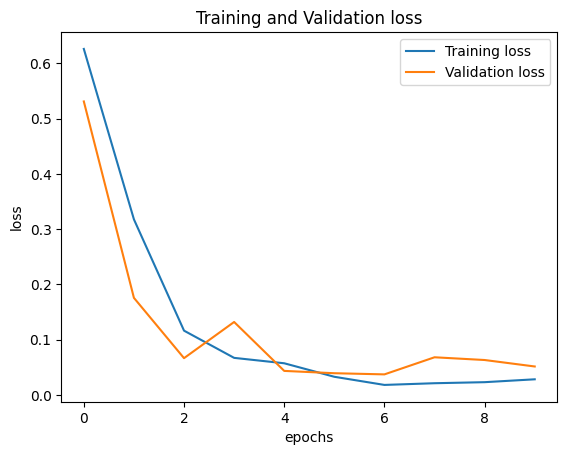

In [16]:
model_performance(history.history['loss'], history.history['val_loss'], 'loss')

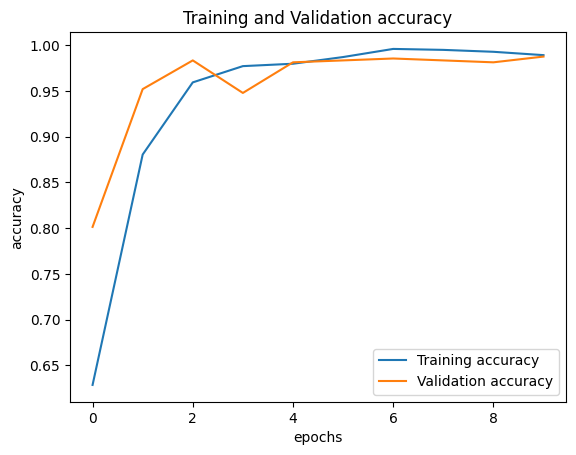

In [17]:
model_performance(history.history['accuracy'], history.history['val_accuracy'], 'accuracy')

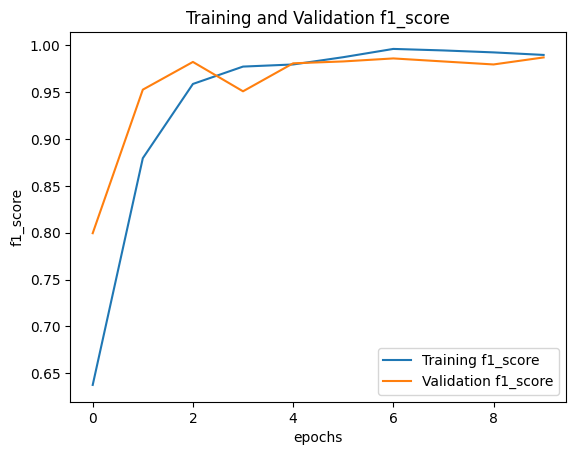

In [18]:
model_performance( history.history['f1_score'], history.history['val_f1_score'], 'f1_score')

### Prediction

first image to predict
actual_label : flip
1/1 [==============================] - 0s 112ms/step
predicted label: flip


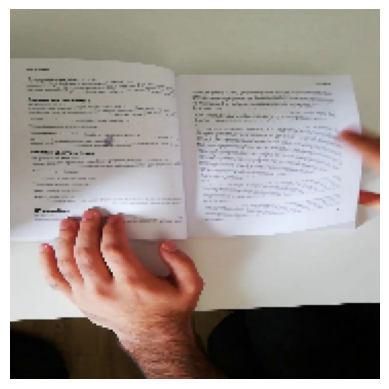

In [19]:
for images_batch,labels_batch in test_set.take(1):
    first_image=images_batch[0].numpy().astype('uint8')
    first_label=labels_batch[0].numpy()

    print('first image to predict')
    plt.imshow(first_image)
    print('actual_label :',class_names[first_label])

    batch_prediction=model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])
    plt.axis('off')
    plt.show()


### Train data with MobileNetV2

In [20]:
# Load pre-trained MobileNetV2 model with imagenet weights
modilenet =  MobileNetV2(include_top=False, weights = 'imagenet', input_shape=(180, 180, 3), pooling='avg')

# Freeze the weights of the pre-trained layers in the MobileNetV2 model
modilenet.trainable = False

# Add new layers on top of the MobileNetV2 model
mobilenet_model = Sequential()
mobilenet_model.add(modilenet)
mobilenet_model.add(Flatten())
mobilenet_model.add(Dense(512, activation='relu'))
mobilenet_model.add(Dense(1, activation='sigmoid'))

mobilenet_model.summary()

9406464/9406464 [==============================] - 0s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 flatten_1 (Flatten)         (None, 1280)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               655872    
                                                                 
 dense_3 (Dense)             (None, 1)                 513       
                                                                 
Total params: 2,914,369
Trainable params: 656,385
Non-trainable params: 2,257,984
_________________________________________________________________


In [21]:
# Compile the model with appropriate loss function and optimizer
mobilenet_model.compile(optimizer = 'adam', loss='binary_crossentropy', metrics=['accuracy',f1_score])

# Train the model on data
history = mobilenet_model.fit(train_set, validation_data=validation_set,epochs=10)

Epoch 1/10
60/60 [==============================] - 8s 65ms/step - loss: 0.6742 - accuracy: 0.6923 - f1_score: 0.6450 - val_loss: 0.4236 - val_accuracy: 0.8117 - val_f1_score: 0.8321
Epoch 2/10
60/60 [==============================] - 2s 42ms/step - loss: 0.3401 - accuracy: 0.8647 - f1_score: 0.8693 - val_loss: 0.3099 - val_accuracy: 0.8808 - val_f1_score: 0.8791
Epoch 3/10
60/60 [==============================] - 2s 39ms/step - loss: 0.2435 - accuracy: 0.9122 - f1_score: 0.9149 - val_loss: 0.2773 - val_accuracy: 0.8787 - val_f1_score: 0.8898
Epoch 4/10
60/60 [==============================] - 2s 36ms/step - loss: 0.1771 - accuracy: 0.9436 - f1_score: 0.9458 - val_loss: 0.1977 - val_accuracy: 0.9331 - val_f1_score: 0.9365
Epoch 5/10
60/60 [==============================] - 2s 36ms/step - loss: 0.1366 - accuracy: 0.9592 - f1_score: 0.9607 - val_loss: 0.1534 - val_accuracy: 0.9477 - val_f1_score: 0.9474
Epoch 6/10
60/60 [==============================] - 2s 40ms/step - loss: 0.1139 - acc

In [22]:
scores_mobilenet = mobilenet_model.evaluate(test_set)

19/19 [==============================] - 1s 55ms/step - loss: 0.1131 - accuracy: 0.9648 - f1_score: 0.9658


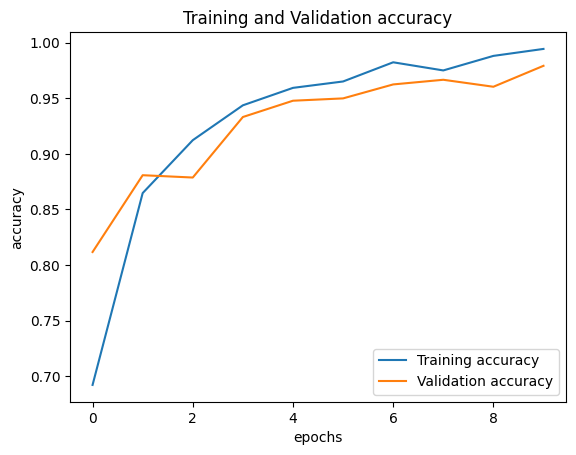

In [23]:
model_performance(history.history['accuracy'], history.history['val_accuracy'], 'accuracy')

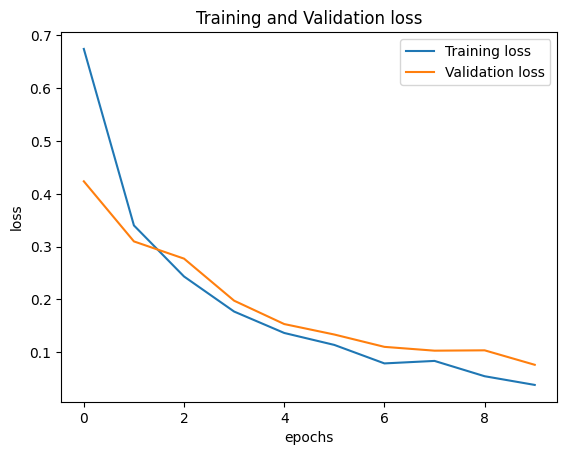

In [24]:
model_performance(history.history['loss'], history.history['val_loss'], 'loss')

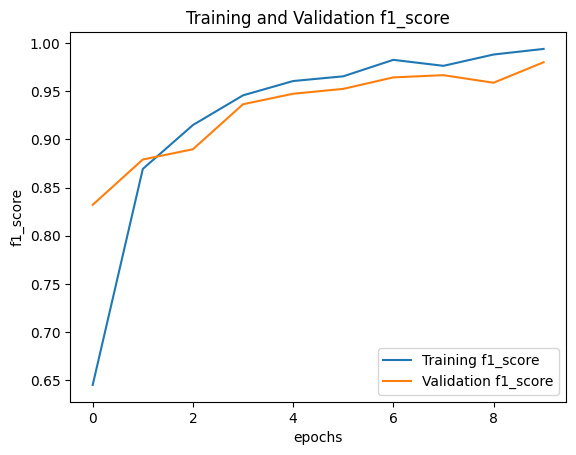

In [25]:
model_performance(history.history['f1_score'], history.history['val_f1_score'], 'f1_score')

### Train data with VGG16

In [38]:
# Load pre-trained VGG16 model with imagenet weights
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(180, 180, 3), pooling='avg')

# Freeze the weights of the pre-trained layers in the VGG16 model
vgg16.trainable = False

# Add new layers on top of the VGG16 model
vgg16_model = Sequential()
vgg16_model.add(vgg16)
vgg16_model.add(Flatten())
vgg16_model.add(Dense(512, activation='relu'))
vgg16_model.add(Dense(1, activation='sigmoid'))

vgg16_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 flatten_4 (Flatten)         (None, 512)               0         
                                                                 
 dense_8 (Dense)             (None, 512)               262656    
                                                                 
 dense_9 (Dense)             (None, 1)                 513       
                                                                 
Total params: 14,977,857
Trainable params: 263,169
Non-trainable params: 14,714,688
_________________________________________________________________


In [39]:
# Compile the model with appropriate loss function and optimizer
vgg16_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', f1_score])

# Train the model on data
history = vgg16_model.fit(train_set, validation_data = validation_set, epochs=10)

Epoch 1/10
60/60 [==============================] - 10s 136ms/step - loss: 0.6283 - accuracy: 0.8245 - f1_score: 0.8079 - val_loss: 0.1962 - val_accuracy: 0.9289 - val_f1_score: 0.9203
Epoch 2/10
60/60 [==============================] - 7s 113ms/step - loss: 0.1063 - accuracy: 0.9634 - f1_score: 0.9656 - val_loss: 0.0811 - val_accuracy: 0.9770 - val_f1_score: 0.9772
Epoch 3/10
60/60 [==============================] - 7s 114ms/step - loss: 0.0541 - accuracy: 0.9848 - f1_score: 0.9860 - val_loss: 0.1097 - val_accuracy: 0.9665 - val_f1_score: 0.9623
Epoch 4/10
60/60 [==============================] - 7s 116ms/step - loss: 0.0335 - accuracy: 0.9906 - f1_score: 0.9904 - val_loss: 0.0399 - val_accuracy: 0.9854 - val_f1_score: 0.9864
Epoch 5/10
60/60 [==============================] - 7s 115ms/step - loss: 0.0193 - accuracy: 0.9953 - f1_score: 0.9957 - val_loss: 0.0267 - val_accuracy: 0.9937 - val_f1_score: 0.9936
Epoch 6/10
60/60 [==============================] - 7s 112ms/step - loss: 0.013

In [40]:
scores_vgg16 = vgg16_model.evaluate(test_set)

19/19 [==============================] - 4s 207ms/step - loss: 0.0185 - accuracy: 0.9933 - f1_score: 0.9937


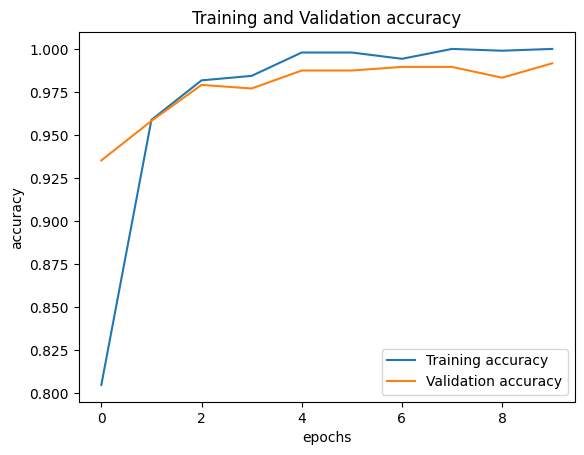

In [28]:
model_performance(history.history['accuracy'], history.history['val_accuracy'], 'accuracy')

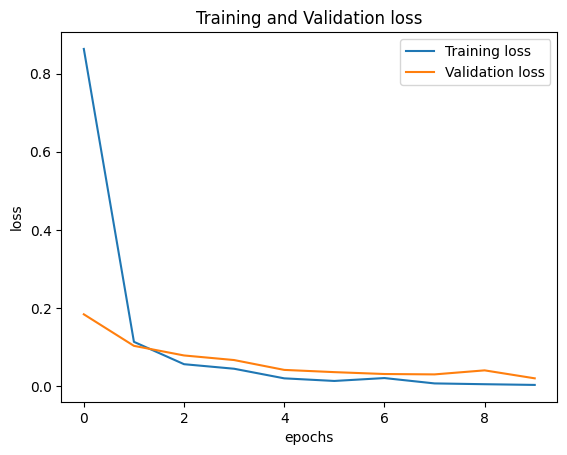

In [29]:
model_performance(history.history['loss'], history.history['val_loss'], 'loss')

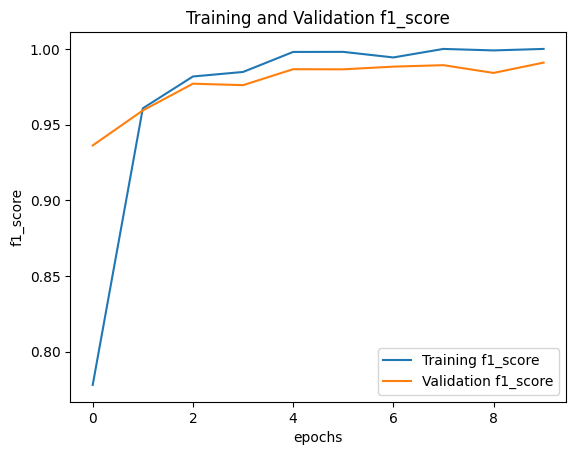

In [30]:
model_performance(history.history['f1_score'], history.history['val_f1_score'], 'f1_score')

### Train data with ResNet50

In [31]:
# Load pre-trained ResNet50 model with imagenet weights
resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(180, 180, 3), pooling='avg')

# Freeze the weights of the pre-trained layers in the ResNet50 model
resnet.trainable = False

# Add new layers on top of the ResNet50 model
resnet_model = Sequential()
resnet_model.add(resnet)
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(1, activation='sigmoid'))

resnet_model.summary()

94765736/94765736 [==============================] - 1s 0us/step
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_3 (Flatten)         (None, 2048)              0         
                                                                 
 dense_6 (Dense)             (None, 512)               1049088   
                                                                 
 dense_7 (Dense)             (None, 1)                 513       
                                                                 
Total params: 24,637,313
Trainable params: 1,049,601
Non-trainable params: 23,587,712
_________________________________________________________________


In [32]:
# Compile the model with appropriate loss function and optimizer
resnet_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', f1_score])

# Train the model on data
history = resnet_model.fit(train_set, validation_data = validation_set, epochs=10)

Epoch 1/10
60/60 [==============================] - 14s 139ms/step - loss: 0.6300 - accuracy: 0.7654 - f1_score: 0.7379 - val_loss: 0.2333 - val_accuracy: 0.9100 - val_f1_score: 0.9135
Epoch 2/10
60/60 [==============================] - 5s 85ms/step - loss: 0.1674 - accuracy: 0.9441 - f1_score: 0.9455 - val_loss: 0.1380 - val_accuracy: 0.9477 - val_f1_score: 0.9475
Epoch 3/10
60/60 [==============================] - 5s 85ms/step - loss: 0.1121 - accuracy: 0.9634 - f1_score: 0.9652 - val_loss: 0.1122 - val_accuracy: 0.9686 - val_f1_score: 0.9674
Epoch 4/10
60/60 [==============================] - 5s 88ms/step - loss: 0.0705 - accuracy: 0.9838 - f1_score: 0.9840 - val_loss: 0.0951 - val_accuracy: 0.9603 - val_f1_score: 0.9600
Epoch 5/10
60/60 [==============================] - 5s 87ms/step - loss: 0.0456 - accuracy: 0.9906 - f1_score: 0.9914 - val_loss: 0.0556 - val_accuracy: 0.9833 - val_f1_score: 0.9833
Epoch 6/10
60/60 [==============================] - 5s 87ms/step - loss: 0.0365 - a

In [33]:
scores_resnet50 = resnet_model.evaluate(test_set)

19/19 [==============================] - 2s 104ms/step - loss: 0.0428 - accuracy: 0.9849 - f1_score: 0.9844


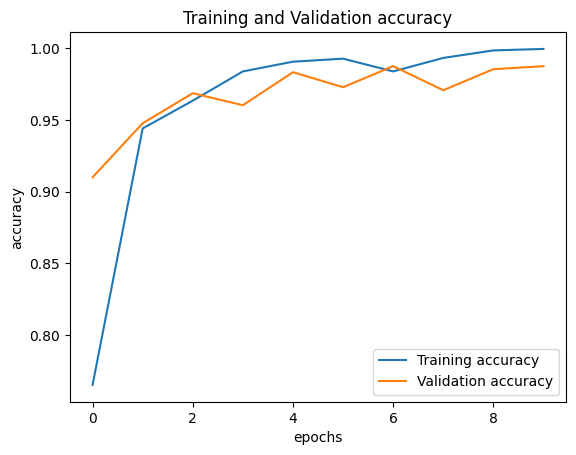

In [34]:
model_performance(history.history['accuracy'], history.history['val_accuracy'], 'accuracy')

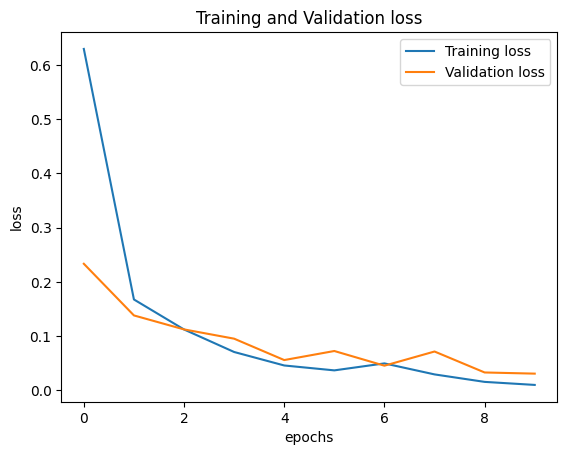

In [35]:
model_performance(history.history['loss'], history.history['val_loss'], 'loss')

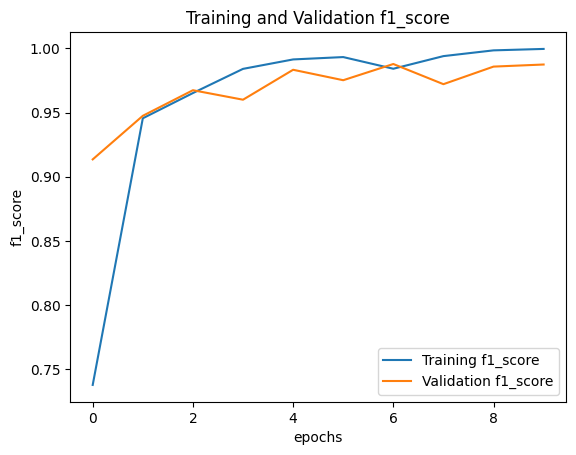

In [36]:
model_performance(history.history['f1_score'], history.history['val_f1_score'], 'f1_score')

### Conclusion

In [41]:
values = {'loss': [scores_cutom_model[0], scores_mobilenet[0], scores_resnet50[0], scores_vgg16[0]],
        'accuracy': [scores_cutom_model[1], scores_mobilenet[1], scores_resnet50[1], scores_vgg16[1]],
        'f1_score': [scores_cutom_model[2], scores_mobilenet[2], scores_resnet50[2], scores_vgg16[2]]}

In [42]:
df = pd.DataFrame(values, index = ['cutom_model', 'mobilenet', 'resnet50', 'vgg16'])
print(df)

                 loss  accuracy  f1_score
cutom_model  0.075369  0.976549  0.974599
mobilenet    0.113107  0.964824  0.965819
resnet50     0.042835  0.984925  0.984379
vgg16        0.018508  0.993300  0.993712


Able to achieve around 99% of accuracy with VGG16 which performs bettern when comparing to other mdoels, hence we can choose VGG16 for production.
